# FINM 33150 Homework 3: Financial Ratio Quantile Strategies

Sean Lin

Student ID: 12375235

***

## 1 Introduction

In this assignment, we create a quantile trading strategy utilizing three ratios: debt-to-market cap, return on investment, and price to earnings. This strategy buys the upper quantile of equities and shorts the lower quantile of equities for some ratio. We examine the chosen ratios and portfolio performance. We also look at other combinations of ratios and compare examine correlations to other factors.

In [1]:
import os 
import warnings
import pandas as pd 
import numpy as np
import quandl 
import random
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime 
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [2]:
KEY = os.getenv('QUANDL_KEY') # If you want to run the notebook on your own, set this to your own API key 
quandl.ApiConfig.api_key = KEY

In [4]:
START_DATE = '2014-09-01' # Start date for all data collection
END_DATE = '2022-01-31' # End date for all data collection
AVAILABLE_PRICE_DATA = True # Is price data corresponding to filtered tickers available?

## 2 Data

In order to use these ratios for trading, they first must be constructed. This data is available through Quandl with `Zacks Fundamentals B`. These ratios must be constructed as the database provides these in a quarterly (and annual) format. However, we want to trade on a more frequent basis and thus will use the given ratios as a baseline before transforming them into (approximate) daily ratios. Although there is a lot of data provided in this database, we will only use a few of these metrics. More specifically, we will use debt/market-cap ratio, return on investment, and price per earnings. We will calculate obtain more metrics from this database in order to calculate our daily ratios. First, we will define some helper functions that will help us in filtering the data. 

***

**2.1 Helper Functions**

These helper functions are as follows: `read_file`, `filter_data`, `download_tickers`, and `get_ff`. The documentation into the purpose of these functions can be found below.

In [5]:
def read_file(filename,start_date=START_DATE,end_date=END_DATE):
    '''
    Obtains financial ratio data within a date range 

    Parameters:
        filename (string): File of the CSV  
        start_date (string): The start date of the price data (default START_DATE)
        end_date (string): The end date of the price data (default END_DATE)

    Returns:
        df (DataFrame): DataFrame consisting of raw financial ratio data within a certain date range 
    '''
    df = pd.read_csv(filename).set_index('ticker')

    if 'per_end_date' in df.columns:
        df['per_end_date'] = pd.to_datetime(df['per_end_date'])
        df = df[(df['per_end_date'] >= pd.to_datetime(start_date)) & (df['per_end_date'] <= pd.to_datetime(end_date))]
    if 'filing_date' in df.columns:
        df['filing_date'] = pd.to_datetime(df['filing_date'])
        df = df[(df['filing_date'] >= pd.to_datetime(start_date)) & (df['filing_date'] <= pd.to_datetime(end_date))]

    df = df.drop_duplicates()
    df = df[df['per_type'] == 'Q'] # Remove all annual data as we only want quarterly 

    return df

In [6]:
def filter_data(filter,*dfs,output=False):
    '''
    Filters an arbitrary number of DataFrames with a specified index filter, leaving only the union of stocks 

    Parameters:
        filter (list): List of stocks to keep 
        output (bool): Whether to output the number of stocks after filtering
        *dfs (DataFrame): Arbitrary number of DataFrames to filter 

    Returns:
        df (DataFrame): DataFrame consisting of raw financial ratio data within a certain date range 
    '''
    filtered = []
    stock_union = []
    for df in dfs: # Filters all DataFrames with the given filter 
        filtered_df = df.loc[df.index.isin(filter)]
        filtered.append(filtered_df)

    if output == True:
        print('Stocks Remaining: ' + str(len(filtered[0].index.unique())))

    return tuple(filtered)

In [7]:
def download_tickers(stocks, start_date=START_DATE, end_date=END_DATE):
    '''
    Downloads daily price data for a list of stocks 

    Parameters:
        stocks (list): List of stocks to download price data of 
        start_date (string): The start date of the price data (default 2014-09-01)
        end_date (string): The end date of the price data (default 2022-01-31)

    Returns:
        price_data (DataFrame): DataFrame consisting of adjusted close price for list of stocks
    '''
    trading_days = quandl.get_table('QUOTEMEDIA/PRICES',date={'gte':START_DATE,'lte':END_DATE},ticker='MSFT').set_index('date').sort_index(ascending=True).index 
    price_data = pd.DataFrame(columns=stocks,index=trading_days)
    for ticker in tqdm(stocks):
        qdata = quandl.get_table('QUOTEMEDIA/PRICES',date={'gte':START_DATE,'lte':END_DATE},ticker=ticker)
        price_data[ticker] = qdata.set_index('date')[['adj_close']]
    return price_data 

In [8]:
def get_ff(filename, start_date=START_DATE, end_date=END_DATE): # This function is obtained from Homework 2 
    '''
    Obtains Fama-French factor daily returns for a given start and end date  

    Parameters:
        filename (string): CSV file of Fama-French factor daily returns 
        start_date (string): The start date of return data (default 2020-12-02)
        end_date (string): The end date of return data (default 2022-11-15)

    Returns:
        filtered_df (DataFrame): DataFrame consisting of Mkt-RF, SMB, HML, RF factors with date index
    '''
    factors = pd.read_csv(filename)
    factors['Unnamed: 0'] = pd.to_datetime(factors['Unnamed: 0'], format='%Y%m%d')
    factors = factors.rename(columns={'Unnamed: 0' : 'Date'}).set_index('Date')
    filtered_df = factors.loc[start_date:end_date]
    return filtered_df

We will now import the quarterly financial ratios: these are directly downloaded from the Quandl website from the `Zack's Fundamentals B` database [here](https://www.quandl.com/api/v3/datatables/ZACKS/MT?qopts.export=true) (MT is linked as a sample) while Fama-French factors are also downloaded from the same [website](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) as last week.

In [9]:
FC = read_file('ZACKS_FC.csv')
FR = read_file('ZACKS_FR.csv')
MKTV = read_file('ZACKS_MKTV.csv')
SHRS = read_file('ZACKS_SHRS.csv')
FF = get_ff('fama_french_factors.csv')

RF = FF['RF'].loc['2015-01-01':'2022-01-31']

***

**2.2 Filtering Stocks**

The main goal of this homework assignment is to get familiar with processing data. In data science, obtaining useful data is one of the most important things as without good data, your models cannot work. Thus, we spend a considerable amount of time ensuring that we have good data. Here, we define good data to be tickers that have all fundamental ratios and prices. We have a few requirements that we want to follow:

1. End-of-day adjusted close prices are available throughout Jan 2015 - Jan 2022

2. Debt / market-cap ratio is greater than 0.1 at least once throughout Jan 2015 - Jan 2022

3. Tickers are not in the automotive, financial, and insurance sectors 

4. The calculation of the desired ratios (debt-to-market-cap, return-on-investment, price-per-earning) can be calculated.

For forming our trading strategy, we need at least 200 stocks, so we can afford to be strict in our filtering. We will see that even while being strict, we are left with more than enough stocks.

***

Below, we will also detail the process for filtering, though this is not necessary to read to understand the project. The rest of the assignment can be understood with the idea that *all remaining stocks has the correct needed data*. For tickers to have all data available, we need to have the adjusted close prices and the ratios. However, the ratios are formed from a composite of other metrics. We will discuss the formation of these metrics later on. Here, we will list the indicators that form these three ratios. Debt/Market-Cap is formed from `FR/TOT_DEBT_TOT_EQUITY`, ROI is formed from `FR/RET_INVST`, `MKTV/MKT_VAL`, `FC/NET_LTERM_DEBT`, and `FC/TOT_LTERM_DEBT`, while price-to-earnings is formed from `FC/EPS_DILUTED_NET`, `FC/BASIC_NET_EPS`, `SHRS/SHARES_OUT`, and `MKTV/MKT_VAL`. It is important to note that we use an *expanded period*. We want to start trading from January 2015; however, we may need financial ratio before then in order to start properly at the time as some of the financial ratios may not be officially reported until after January 2015. Companies officially calculate their ratios at some period end date, but don't officially report them until some time later at the filing date. Thus, we start our period in September 2014 to ensure we have all the needed data. 

First, in order to have all needed data, the tickers must be present in all the DataFrames. Thus, we first find the set of tickers that are present in all DataFrames and remove all other tickers. We utilize the function `filter_data` in order to remove tickers from an arbitrary number of DataFrames. We then filter out the industry as well as determine the stocks that are only present in our chosen timeframe. Since our time-interval is 7 years, we must have 28 total readings (4 quarters per year). Afterwards, we drop any stocks that have NaN columns in any metrics (i.e market value, total-debt-to-equity) or those with duplicate columns (i.e filing and period end dates). We only need 200 stocks, so it is okay to be aggressive in our filtering. 

During this process, we also replace `NET_LTERM_DEBT` with `TOT_LTERM_DEBT` and `EPS_DILUTED_NET` with `BASIC_NET_EPS` whenever needed. This is an assumption that is made in the homework. Additionally, we ensure we only have positive values of `EPS_DILIUTED_NET` by changing all negative values to $0.001$. Additionally, we also change all values of $0.00$ to $0.001$ to avoid any undefined ratios. After our initial round of filtering, we are left with 1074 stocks from 7446 unique stocks. Comments are left in the code so the reader can understand the filtering process more thoroughly.

In [10]:
shared_filter = list(set(FR.index.unique()) & set(FC.index.unique()) & set(MKTV.index.unique()) & set(SHRS.index.unique())) # Keeps only unique stocks (present in FR, FC, MKTV, and SHRS)
print('Initial Number of Unique Stocks: ' + str(len(shared_filter)))
FC, FR, MKTV, SHRS = filter_data(shared_filter, FC, FR, MKTV, SHRS)

industry_filter = FC[~FC['zacks_sector_code'].isin([5.0,13.0])].index.unique() # Eliminates stocks in financial, insurance, or automotive industries 
FC, FR, MKTV, SHRS = filter_data(industry_filter, FC, FR, MKTV, SHRS)  

subsample = FR[(FR['per_end_date'] > datetime(2015,1,1)) & (FR['per_end_date'] < datetime(2022,1,1))] # Only checks our desired time period (Jan 2015 - Jan 2022)
debt_mc_filter = subsample[subsample['tot_debt_tot_equity'] > 0.1].groupby('ticker').first().index # Eliminates all stocks that don't have debt/market cap ratios more than 0.1 during our period
FC, FR, MKTV, SHRS, subsample = filter_data(debt_mc_filter, FC, FR, MKTV, SHRS, subsample)

quarterly_data_size = subsample.loc[subsample['per_type'] == 'Q'].groupby('ticker').size() # There should be 28 quarterly data points from January 2015 - January 202022 
quarterly_filter = subsample[quarterly_data_size == 28].index.unique() # Filters equities that don't meet this requirement 
FC, FR, MKTV, SHRS = filter_data(quarterly_filter, FC, FR, MKTV, SHRS)

na_filing_filter = FC[FC.groupby('ticker')['filing_date'].apply(lambda x: x.notna().all())].index.unique() # Filters stocks with a NaN filing date  
FC, FR, MKTV, SHRS = filter_data(na_filing_filter, FC, FR, MKTV, SHRS)

duplicate_filing_filter = FC[FC.groupby('ticker')['filing_date'].apply(lambda x: ~x.duplicated().any())].index.unique() # Filing dates should be unique for every stock -- no duplicates 
FC, FR, MKTV, SHRS = filter_data(duplicate_filing_filter, FC, FR, MKTV, SHRS)

full_dte_filter = FR[FR.groupby('ticker')['tot_debt_tot_equity'].apply(lambda x: x.notna().all())].index.unique() # Filters tickers with NaN total-debt-total-equity ratios 
FC, FR, MKTV, SHRS = filter_data(full_dte_filter, FC, FR, MKTV, SHRS)

invst_filter = FR[FR.groupby('ticker')['ret_invst'].apply(lambda x: x.notna().all())].index.unique() # Filters tickers with NaN return on investments
FC, FR, MKTV, SHRS = filter_data(invst_filter, FC, FR, MKTV, SHRS)

mkt_filter = MKTV[MKTV.groupby('ticker')['mkt_val'].apply(lambda x: x.notna().all())].index.unique() # filters tickers with NaN market value 
FC, FR, MKTV, SHRS = filter_data(mkt_filter, FC, FR, MKTV, SHRS)

FC['net_lterm_debt'] = FC['net_lterm_debt'].fillna(FC['tot_lterm_debt']) # Uses total long term debt when net long term debt is NaN
debt_filter = FC[FC.groupby('ticker')['net_lterm_debt'].apply(lambda x: x.notna().all())].index.unique() # Filters tickers with NaN net long term debt even after filling with total long term debt 
FC, FR, MKTV, SHRS = filter_data(debt_filter, FC, FR, MKTV, SHRS)

FC['eps_diluted_net'] = FC['eps_diluted_net'].fillna(FC['basic_net_eps']) # Uses basic net eps if eps diluted net is NaN
eps_filter = FC[FC.groupby('ticker')['eps_diluted_net'].apply(lambda x: x.notna().all())].index.unique() # Filters tickers with NaN diluted eps even after filling with basic net EPS 
FC, FR, MKTV, SHRS = filter_data(eps_filter, FC, FR, MKTV, SHRS)
FC['eps_diluted_net'] = np.where(FC['eps_diluted_net'] <= 0, 0.001, FC['eps_diluted_net']) # Replaces zero and negative EPS with 0.001 

shares_filter = SHRS[SHRS.groupby('ticker')['shares_out'].apply(lambda x: x.notna().all())].index.unique() # Filters stocks with NaN shares_out 
FC, FR, MKTV, SHRS = filter_data(shares_filter, FC, FR, MKTV, SHRS)

FR = FR[['per_end_date','ret_invst','tot_debt_tot_equity']] # Only keeps the relevant metrics 
FC = FC[['per_end_date','filing_date','net_lterm_debt','eps_diluted_net']]
MKTV = MKTV[['per_end_date','mkt_val']]
SHRS = SHRS[['per_end_date','shares_out']]

financial_ratios = pd.merge(FC, FR, on=['per_end_date','ticker']) # These merges get rid of non-overlapping period end dates and filing dates  
financial_ratios = pd.merge(financial_ratios, MKTV, on=['per_end_date','ticker'])
financial_ratios = pd.merge(financial_ratios, SHRS, on=['per_end_date','ticker'])

stocks = financial_ratios.index.unique().astype('string') 
print('Stocks Remaining: ' + str(len(stocks)))

Initial Number of Unique Stocks: 7446
Stocks Remaining: 1074


We have now done our initial filtering in terms of the financial ratios. However, we need stocks that have adjusted closing prices for the entire time period. It is now a good time to download price data before doing further filtering. The time for the next step is dependent on the number of stocks we want, so it is good to filter as much as possible before downloading data to reduce the time. The price data could've also been downloaded at the beginning, but it would've left a lot of unneeded and redundant stocks.

***

**2.3 Downloading Price Data**

In [11]:
if AVAILABLE_PRICE_DATA: # If you have price data that corresponds to the filtering above, this can be set to True, otherwise, run the code
    price_data = pd.read_csv('stocks_prices.csv').set_index('date')
    price_data.index = pd.to_datetime(price_data.index)
else:
    price_data = download_tickers(stocks) # This takes about 10 minutes, depending on current traffic 
    price_data.to_csv('stock_prices.csv')

We need complete closing price data, so we will drop any stocks that don't have adjusted closing prices for every single trading day. We will then filter the financial ratios with the updated stock list from our stock prices. In other words, we obtained a list of stocks from our first round of financial ratio filtering. We then obtained the price data of this stock list. However, not all of the stock list has all prices. Thus, we must filter empty stocks with empty prices before refiltering our financial ratios.

In [12]:
subsample = price_data.loc['2015-01-01':] # Allow ous to specifically examine our subsample (our date)
subsample = subsample.dropna(axis=1,how='any')

stocks = subsample.columns 
financial_ratios = financial_ratios.loc[financial_ratios.index.isin(stocks)]

subsample_dates = subsample.index 
trading_days = price_data.index 
ratio_dates = pd.to_datetime(financial_ratios['filing_date'].unique())
all_dates = pd.to_datetime(list(set(trading_days) | set(ratio_dates))).unique() # This all_dates variable will be very useful later as it includes filing dates AND trading days 

print('Stocks Remaining: ' + str(len(stocks)))

Stocks Remaining: 1006


We go from 1074 to 1006 stocks. We have now eliminated about 6000 stocks since the first iteration (after only gathering the unique stocks). We have all the data needed to create our ratios: we will do this next.

***

## 3 Ratio Construction

In this section, we will construct the ratios that we will use for quantile trading. As a reminder, these are debt-to-market cap, return-on-investment, and price-per-earnings. We will elaborate on ratio construction later in the code. However, they all rely on a similar concept. This concept is as follows: these metrics are calculated by the company on the `per_end_date` (or period end date). However, these aren't revealed to the public until the `filing_date`. As a result, we cannot react to this data until $T + 1$ days. In order to calculate the ratios, we will use the base values at each filing_date before updating them later on. As a result, we need to know these values at every date after the filing_date in order to make these updates. In other words, these values stay constant after the filing date and remain constant until the next filing date. We will make use of the helper function `create_table` in order to calculate the base values for every date before updating them later on. The `reindex` function is also used to easily change the index of the DataFrames (i.e change the dates to our subsample)

***

**3.1 Helper Functions**

In [13]:
def create_table(column,end_date_prices=False,data=financial_ratios,stocks=stocks,dates=all_dates):
    '''
    Creates a table with the index of every day and all allowable stocks and forward fills with the desired financial ratio 

    Parameters:
        column (string): The chosen ratio 
        end_date_prices (bool): Choice to include sorting on per_end_date rather than filing_date (used for per_end_date prices)
        data (DataFrame): DataFrame consisting of the available financial ratios (default financial_ratios DataFrame from earlier)
        dates (list): Dates for the table to cover (defaults to all_dates)

    Returns:
        df (DataFrame): DataFrame consisting of forward-filled chosen financial ratio data for all stocks 
        stocks (list): List of stocks with valid entries in the chosen time-period 
    '''
    df = pd.DataFrame(columns=stocks,index=dates).sort_index()
    for name, data in tqdm(data.groupby('ticker')):
        if not end_date_prices:
            col = data.set_index('filing_date')[column]
            df[name] = col 
        else:
            dates = data[['per_end_date','filing_date']].set_index('per_end_date')
            dates['price'] = price_data[name]
            for d in dates.index: # The period end date may not be a trading day, so we need to go backwards until we get to the last trading day available to obtain the price 
                if np.isnan(dates.loc[d,'price']):
                    shift = 1
                    while np.isnan(dates.loc[d,'price']):
                        d_new = d - pd.DateOffset(days=shift)
                        if d_new in price_data.index:
                            dates.loc[d,'price'] = price_data.loc[d_new].values[0]
                        shift += 1
            dates = dates.set_index('filing_date')
            df[name] = dates 
    
    df = df.shift() # We need to shift the data as the information is not revealed until the day after the filing date 
    df = df.ffill()
    df = df.loc['2015-01-01':]
    df = df.dropna(axis=1, how='any')

    stocks = df.columns.to_list()

    return df, stocks 

def reindex(df, dates=trading_days):
    '''
    Simple function for reindexing a DataFrame based on a certain date range 

    Parameters:
        df (DataFrame): DataFrame to be reindexed 
        dates (list): List of dates to reindex the DataFrame (defaults to trading_days)

    Returns:
        df (DataFrame): Original DataFrame reindexed to some new index 
    '''  
    return df[df.index.isin(trading_days)]

***

**3.2 Debt-To-Market-Capital Ratio**

The debt-to-market-capital ratio is calculated as the follows: $\text{tot\_debt\_tot\_equity} * \frac{P_t}{P_0}$. Here, *tot_debt_tot_equity* is the ratio given each period (revealed at the filing date) multiplied by the change in price from the *period end date*. The period end date is used as this is when the metrics are actually calculated: they are just revealed at the filing date. As a reult, we will calculate the per_end_date price and the tot_debt_tot_equity table. The per_end_date_price is the reason why we have the option to sort based on end_date_price in the `create_table` function.

The per_end_date_prices contains the prices the day of the per_end_date for each period. This allows us to know what the change in price is for any day in any given period.

In [14]:
dte, stocks = create_table('tot_debt_tot_equity')
subsample, financial_ratios = subsample[stocks], financial_ratios.loc[stocks]

per_end_date_prices, stocks = create_table(None,end_date_prices=True)
subsample, financial_ratios, dte = subsample[stocks], financial_ratios.loc[stocks], dte[stocks]

dte_td = reindex(dte)
per_end_date_prices_td = reindex(per_end_date_prices) # Here, the _td subscript indicates that the DataFrame corresponds to only the trading days in the actual sample 

debt_to_mkt_cap = (dte_td * per_end_date_prices_td) / subsample 

100%|██████████| 1006/1006 [00:07<00:00, 143.06it/s]


We also reindex our financial ratio as we only are concerned with trades from Jan 2015 - Jan 2022.

***

**3.3 Return on Investment Ratio**

Return on investment is calculated as $\frac{R}{M + D}$ where R corresponds to the return, M corresponds to the market capitalization, and D corresponds to the debt. In order to calculate this ratio, we must know the reward. We can calculate the reward from the period end date as we know the values of M and D (they are revealed at the filing date) for each period. This can be calculated as $R = V * (M + D)$ where V is the associated ratio revealed to us at the filing date. Once we obtain R, we can assume this to be constant (and D) throughout the next period. However, M changes throughout. M is defined to be the change in the market capitalization and thus can be calculated by $M = M_0 \frac{P_t}{P_0}$ where $M_0$ and $P_0$ are the market capitalizations revealed at the filing date and period end date price respectively. $P_t$ is the price at any given day in the period.

In [15]:
ret_invst, stocks = create_table('ret_invst')
subsample, financial_ratios = subsample[stocks], financial_ratios.loc[stocks]

debt_num, stocks = create_table('net_lterm_debt')
subsample, financial_ratios = subsample[stocks], financial_ratios.loc[stocks]

mkt_val, stocks = create_table('mkt_val')
subsample, financial_ratios = subsample[stocks], financial_ratios.loc[stocks]

ret_invst, debt_num, mkt_val = ret_invst[stocks], debt_num[stocks], mkt_val[stocks]
debt_to_mkt_cap, per_end_date_prices_td = debt_to_mkt_cap[stocks], per_end_date_prices_td[stocks]

ret_invst_td = reindex(ret_invst)
debt_num_td = reindex(debt_num)
mkt_val_td = reindex(mkt_val)

dP = subsample/ per_end_date_prices_td # Ratio of the change in price from the period end date 
R = ret_invst_td * (debt_num_td + mkt_val_td) # Calculating the initial value of R 
return_on_inv = R / (debt_num_td + (mkt_val_td * dP)) 

100%|██████████| 1006/1006 [00:05<00:00, 197.00it/s]


Now that we calculated return on investment, we only need one more ratio: the price to earning. Luckily, this is the easiest to calculate.

***

**3.4 Price Per Earnings**

This ratio is relatively simple. We have the earnings per share from a period, which we can forward fill to approximate the EPS for the remainder of the quarter. However, we have the price for every day. We can thus divide the price by earnings / share to obtain the price / earning. From earlier, we made all EPS values less than equal to 0 to 0.001. This removes negative EPS values as well as any potential divide by zero problems.

In [16]:
eps, stocks = create_table('eps_diluted_net')

debt_to_mkt_cap, return_on_inv, subsample = debt_to_mkt_cap[stocks], return_on_inv[stocks], subsample[stocks]

eps_td = eps[eps.index.isin(trading_days)]
price_to_earnings = subsample / eps_td 

100%|██████████| 1006/1006 [00:05<00:00, 198.76it/s]


In [17]:
print('Remaining Stocks: ' + str(len(stocks)))

Remaining Stocks: 978


After constructing all the ratios and reindexing, we are now left with 978 stocks. We can now move on from data collection and begin analyzing our data. From examining the code above, you may also notice that the DataFrames are constantly reindexed. This is to potentially remove any errors that may have appeared while trying to forward-fill and generate these ratios. Let's now examine some of these ratios to understand how they move.

***

**3.5 Ratio Validation**

We are given ratios for $LLY to verify that we did this correctly. Let's show that we get the same values for *some* of these dates.

In [18]:
v1 = debt_to_mkt_cap[['LLY']].loc[['2020-10-28','2021-09-30','2021-12-31']].rename(columns={'LLY':'Debt-to-market cap'})
v2 = return_on_inv[['LLY']].loc[['2020-10-28','2021-09-30','2021-12-31']].rename(columns={'LLY':'Return on investment'})
v3 = price_to_earnings[['LLY']].loc[['2020-10-28','2021-09-30','2021-12-31']].rename(columns={'LLY':'Return on investment'})

validation = pd.concat([v1,v2,v3],axis=1)
validation

,Debt-to-market cap,Return on investment,Return on investment
2020-10-28,4.755473,9.075546,81.908198
2021-09-30,2.454071,6.436395,148.509924
2021-12-31,1.790877,3.943927,223.385833


We see that all these values match with the ratios provided in the PDF. Now, we will take a closer look at these ratios.

***

**3.6 Examining Ratios**

Let's examine the trends of these ratios. These are ratios, so let's look at how these ratios trend in the overall market as the economy moves. This may not be completely representative of the entire market as it doesn't contain all stocks, but we have a good approximation. The S&P 500 only contains about 500 stocks and is generally used as a metric. However, we are unsure of the types of stocks in our sample. To judge this, we will examine the median and the mean of the ratios as a function of time. The data may be skewed (as there are some extremely large companeis like $AAPL and $MSFT). We expect that median could be a better representation as it's less prone to outliers. Nonetheless, we will plot both. We will first start with the debt-to-market cap ratio.

Text(0.5, 1.0, 'Debt-to-Market Cap Ratio')

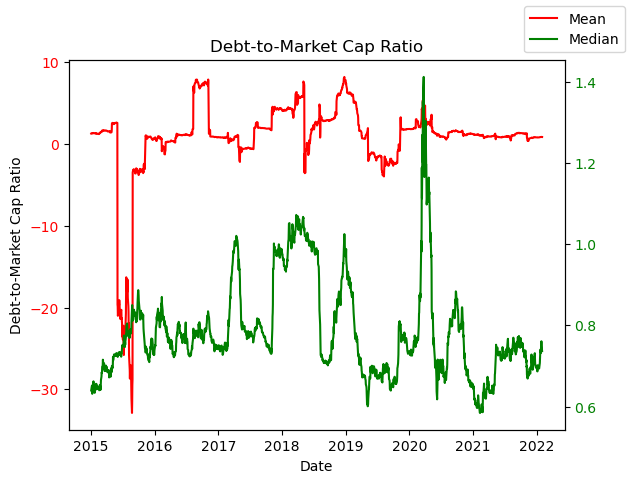

In [19]:
fig, ax = plt.subplots()
ax.set_xlabel('Date')
ax.set_ylabel('Debt-to-Market Cap Ratio')
ax.tick_params(axis='y',labelcolor='red')
ax.plot(debt_to_mkt_cap.index, debt_to_mkt_cap.mean(axis=1),color='red',label='Mean')

ax2 = ax.twinx()
ax2.plot(debt_to_mkt_cap.index, debt_to_mkt_cap.median(axis=1),color='green',label='Median')
ax2.tick_params(axis='y',labelcolor='green')
fig.legend()
plt.title('Debt-to-Market Cap Ratio')

We can see that the median appears to be a better metric. We see a huge jump in the ratio around 2020, which is when the COVID-19 pandemic hit. Many companies suffered huge losses and as a result, the companies gained huge amounts of debt. This is in-line with what we expect. However, the mean doesn't really fluctuate much, potentially telling us there are huge outliers (i.e megacap tech stocks before the tech crash in 2022). Let's look at return-on-investment ratio next.

Text(0.5, 1.0, 'Return on Investment Ratio')

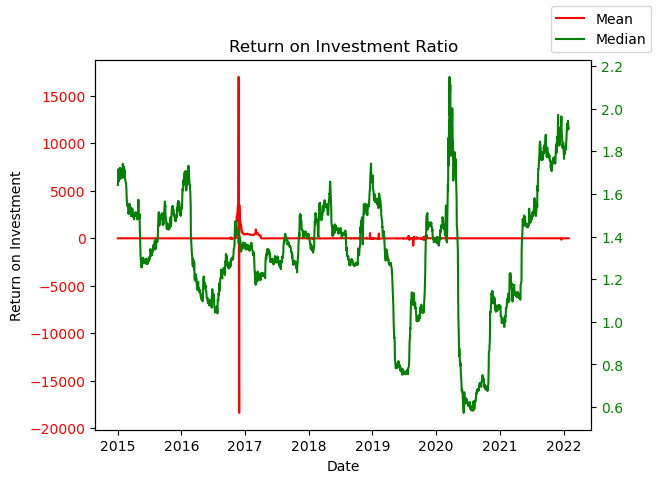

In [20]:
fig, ax = plt.subplots()
ax.set_xlabel('Date')
ax.set_ylabel('Return on Investment')
ax.tick_params(axis='y',labelcolor='red')
ax.plot(return_on_inv.index, return_on_inv.mean(axis=1),color='red',label='Mean')

ax2 = ax.twinx()
ax2.plot(return_on_inv.index, return_on_inv.median(axis=1),color='green',label='Median')
ax2.tick_params(axis='y',labelcolor='green')
fig.legend()
plt.title('Return on Investment Ratio')

We see a similar effect here: the median is a much better. It's interesting to see how skewed the mean is. This can be attributed to the wide range of companies -- some very large and others very small. We can see the effect of the pandemic. The median ROI decreased drastically, in-line with what we would expect. Let's look at the kurtosis for ROI.

In [49]:
print('Kurtosis: ' + str(round(return_on_inv.mean(axis=1).kurtosis(),3)))

Kurtosis: 649.602


We see that the kurtosis of the means is extremely high. This is in line with the huge peak that we see in the ROI plot. Let's look at price-to-earnings now.

Text(0.5, 1.0, 'Price to Earnings Ratio')

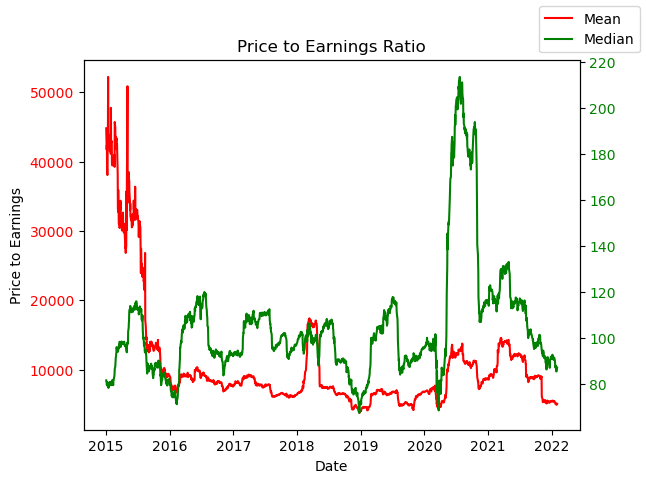

In [51]:
fig, ax = plt.subplots()
ax.set_xlabel('Date')
ax.set_ylabel('Price to Earnings')
ax.tick_params(axis='y',labelcolor='red')
ax.plot(price_to_earnings.index, price_to_earnings.mean(axis=1),color='red',label='Mean')

ax2 = ax.twinx()
ax2.plot(price_to_earnings.index, price_to_earnings.median(axis=1),color='green',label='Median')
ax2.tick_params(axis='y',labelcolor='green')
fig.legend()
plt.title('Price to Earnings Ratio')

We see an interesting trend. We see the average PPE decrease dramatically throughout the decade while the median stays about the same. This could potentially be explained by the economic growth experienced after The Great Financial Crisis. Once again, we see a similar effect with the previous ratios when looking around 2020. During the pandemic era, we see a large increase in the PPE median before tanking. This could be explained by the sudden decrease in rates, resulting in the big stock market rally. However, once the effects of the pandemic were felt, the earnings of the companies decreased.

In this section, we see that the median acts as a better metric when looking at these financial ratios. This can be explained by the wide variety of companies (i.e certain companies have very large capitalizations). We also see the effects of COVID in all three metrics with the huge spikes or dips around 2020. Let's look at how correlated these financial ratios are.

<AxesSubplot: >

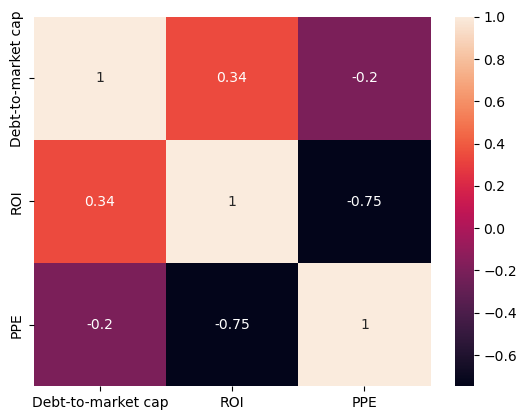

In [129]:
median_factors = pd.concat([debt_to_mkt_cap.median(axis=1),return_on_inv.median(axis=1),price_to_earnings.median(axis=1)],axis=1)
median_factors.columns = ['Debt-to-market cap','ROI','PPE']
sns.heatmap(median_factors.corr(), annot=True)

We see that for the most part, the correlation between the ratios isn't too high. We see that the highest correlation is between ROI and debt-to-market cap with a coefficient of 0.34 while the loweest correlation is between PPE and ROI with a correlation of -0.75. This negatie correlation can potentially be explained as when a company's PPE increases, they become more overvalued at and as a result, the return on investment is less. We'll look at the actual quantile trading strategies next.

***

## 4 Quantile Trading Strategies

We have now calculated the financial ratios we want to use as well as plotted them to see how they work. We see that the median tends to stay around a certain value, almost like it's reverting. However, we see huge spikes in all three ratios. It would not be a good idea to assume stationarity as these events could destroy a portfolio in a single trade, especially if not managed correctly. Instead, it might be better to evaluate the ratios at any given time-interval and buy stocks that are the best in their quantile and short the ones that are the worst in their quantile, hence quantile trading. To make things easier, we will define three functions: `standardize`, `simulate`, and `metrics`. `standardize` will convert a ratio into a standardized z-score, such that they are unitless and can be compared with each other. `simulate` will conduct a backtest given certain parameters. `metrics` will calculate portfolio performance metrics for our portfolio. These documentation for the functions can be seen below. We will talk about the methodology of our strategy later on in this section.

***

**4.1 Helper Functions**

In [52]:
def standardize(row): 
    '''
    Standardizes a row of a DataFrame to the mean and standard deviation of the row  

    Parameters:
        row (DataFrame): The row of a DataFrame needing to be standardized

    Returns:
        df (DataFrame): The row of the DataFrame with all values standardized 
    '''
    return (row - row.mean()) / row.std()

In [179]:
def simulate(signal,notional,prices,period='W',upper_quantile=0.9,lower_quantile=0.1,use_more_quantiles=False,additional=0.15):
    '''
    Simulates a backtest with a given signal and calculates the cumulative PnL 

    Parameters:
        signal (DataFrame): The DataFrame consisting of the signal that quantile trading is done on 
        notional (int): The notional value of long and short positions 
        prices (DataFrame): DataFrame consisting of stock prices for our time period (default subsample)
        period (string): The time-period of which the backtest is conducted on (usually 'W' or 'M')
        upper_quantile (float): The percentile of which we will long 
        lower_quantile (float): The percentile of which we will short 
        use_more_quantiles (bool): Whether to change from equal allocation
        additional (float): The amount at which we extend from the upper and lower quantiles on both sides (default 0.15)

    Returns:
        pnl (DataFrame): DataFrame consisting of our daily PnL
        cum_pnl (DataFrame): DataFrame consisting of cumulative PnL
        portfolio_value (DataFrame): DataFrame consisting of the portfolio value (cumulative PnL + K)
    '''
    pnl = pd.DataFrame(columns=['PnL'])
    K = 2 * notional * 10 
    for date, data in signal.groupby(signal.index.to_period(period)):
        num_days = len(data)
        if num_days == 1:
            continue 
        
        first_day, last_day = data.index[0], data.index[-1]
        metric = data.loc[first_day]

        upper, lower = metric.quantile(upper_quantile), metric.quantile(lower_quantile)
        long_stocks = metric[metric >= upper].index.astype('string')
        short_stocks = metric[metric <= lower].index.astype('string')

        n_long, n_short = len(long_stocks), len(short_stocks)
        stock_list = long_stocks.append(short_stocks)

        long_dollar_amt, short_dollar_amt = (1/n_long)*notional, (1/n_short)*notional 

        long_quantity = long_dollar_amt / subsample.loc[[first_day]][long_stocks]
        short_quantity = -short_dollar_amt / subsample.loc[[first_day]][short_stocks]

        if use_more_quantiles == True: # We will default to the next 15-percentile above / below the ones we chose
            long_dollar_amt /= 2
            short_dollar_amt /= 2
            upper2, lower2 = metric.quantile(upper_quantile - additional), metric.quantile(lower_quantile + additional)
            long_stocks2 = metric[(metric >= upper2) & (metric <= upper)].index.astype('string')
            short_stocks2 = metric[(metric <= lower2) & (metric >= lower)].index.astype('string')
            stock_list = stock_list.append(long_stocks2)
            stock_list = stock_list.append(short_stocks2)

            n_long2, n_short2 = len(long_stocks2), len(short_stocks2)
            long_dollar_amt2, short_dollar_amt2 = (1/n_long2)*(notional/2), (1/n_short2)*(notional/2)

            long_quantity2 = long_dollar_amt2 / subsample.loc[[first_day]][long_stocks2]
            short_quantity2 = -short_dollar_amt2 / subsample.loc[[first_day]][short_stocks2]

            short_dollar_amt += short_dollar_amt2 
            long_dollar_amt += long_dollar_amt2 

        dP = (subsample.loc[[last_day]][stock_list].reset_index() - subsample.loc[[first_day]][stock_list].reset_index()).drop(columns='date')

        added_interest = short_dollar_amt * (RF.loc[first_day] - .01) # Adding financing rates (using risk-free rate from Fama-French factors)

        if use_more_quantiles:
            quantities = pd.concat([long_quantity, long_quantity2, short_quantity, short_quantity2], axis=1)
        else:
            quantities = pd.concat([long_quantity, short_quantity], axis=1)
        pnl.loc[last_day] = added_interest + ((quantities.reset_index().drop(columns='date') * dP).sum(axis=1)).item()

    cum_pnl = pnl.cumsum()
    portfolio_value = cum_pnl + K 

    return pnl, cum_pnl, portfolio_value

In [116]:
def metrics(port,annualization=52):
    '''
    Calculates performance metrics for a given portfolio 

    Parameters:
        port (DataFrame): Time-series of portfolio value 
        annualization (int): Value to annualize the data (default 52)

    Returns:
        metrics (DataFrame): DataFrame consisting of various performance metrics 
    '''
    metrics = pd.DataFrame()
    rets = port.pct_change()
    metrics['Mean'] = annualization * rets.mean()
    metrics['Volatility'] = np.sqrt(annualization) * rets.std()
    metrics['Sharpe Ratio'] = metrics['Mean'] / metrics['Volatility']
    metrics['VaR (.05)'] = rets.quantile(.05)
    metrics['CVaR (.05)'] = rets[rets < rets.quantile(.05)].mean()
    metrics['Skewness'] = rets.skew()
    metrics['Kurtosis'] = rets.kurtosis()

    downside_returns = rets[rets < 0]
    down_std = np.sqrt(12) * downside_returns.std()
    metrics['Sortino Ratio'] = metrics['Mean'] / (np.sqrt(12) * down_std)

    return metrics

We will also standardize our data. To repeat, the data is standardized based on the current day since we are trading with the adjusted close prices. We have seen that these ratios have very massive shocks, so it would be unwise (and potentially career ending) to trade a mean-reversion strategy as a single event could wipe out years of returns.

In [117]:
dmc_std = debt_to_mkt_cap.apply(standardize, axis=1)
roi_std = -return_on_inv.apply(standardize, axis=1)
ppe_std = -price_to_earnings.apply(standardize, axis=1)

Here, we also choose to flip the quantile of certain metrics. We will keep the debt-to-mkt cap ratio as it is but will flip ROI and price-to-earnings. From running simulations, performance is better when these ratios are switched to the negative. Logically, a high price to earnings means that the stock is overpriced and thus you should short it. Similarly, a high return on investment means that the stock has high returns and is likely to revert. There are also likely other reasons, potentially due to the timeframe of our sample (i.e COVID-19), which could lead to some overfitting and bias, but we will go with this for the remainder of the assignment.

***

**4.2 Quantile Trading**

Our quantile trading strategy is as follows. Every week (the first day of the week), we will examine the top and bottom quantiles for a certain metric. We will buy the stocks in the top quantile and short the stocks in the lowest quantile. As a result, we will have a net $0 position, although we will collect interest on our short position (if the rate is favorable.. or pay). We will use the risk-free rate provided from the Fama-French factors as the interest rate associated with short positions. At the end of the week, we will then liquidate our positions and then repeat the following week. This process can also be done for other timeframes, like monthly. First, we will look at a evenly distributed portfolio (i.e the dollar size for all positions will be equal). We assume we can hold fractional shares and that there are no trading costs. 


Here, we will use all 978 stocks in our universe as we know that these 978 stocks have all the data needed. However, we also have the ability to randomly sample (as se have 978 stocks). We will also assume a gross initial value of $100k (or $50k for long and short positions so that our net position is $0). We will also assume the standard quantiles of 0.9 and 0.1. We will plot our our portfolio values as a function of time. Namely, each of our portfolio is based solely on one financial ratio (either debt-to-market-cap, return-on-investment, or price-per-earnings). For the rest of the assignment, we will use the full sample of 978 stocks.

Text(0.5, 1.0, 'Portfolio Value over Time (Weekly)')

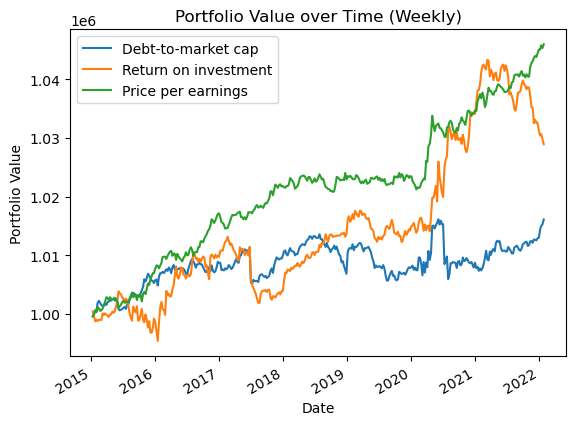

In [118]:
_, _, dmc_port = simulate(dmc_std[stocks],50000,subsample[stocks])
_, _, roi_port = simulate(roi_std[stocks],50000,subsample[stocks])
_, _, ppe_port = simulate(ppe_std[stocks],50000,subsample[stocks])

portfolio_first = pd.concat([dmc_port.rename(columns={'PnL':'Debt-to-mkt cap'}),roi_port.rename(columns={'PnL':'RoI'}),ppe_port.rename(columns={'PnL':'PPE'})],axis=1)
portfolio_first.plot()

plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend(['Debt-to-market cap','Return on investment','Price per earnings'])
plt.title('Portfolio Value over Time (Weekly)')

In [119]:
metrics(portfolio_first)

,Mean,Volatility,Sharpe Ratio,VaR (.05),CVaR (.05),Skewness,Kurtosis,Sortino Ratio
Debt-to-mkt cap,0.002331,0.006038,0.385998,-0.000892,-0.001878,-1.752295,20.619772,0.251756
RoI,0.004002,0.008075,0.495611,-0.001364,-0.002134,0.868946,6.220336,0.498440
PPE,0.006419,0.004261,1.506665,-0.000776,-0.000981,0.901946,3.667057,1.801505


We see that the price-per earnings portfolio performs the best followed by the return-on-investment. We see that the PPE portfolio has an incredibly high Sharpe Ratio of 1.51. It also has a very high Sortino ratio of 1.80. We also see an extremely high kurtosis for the debt-to-mkt-cap portfolio. However, let's see if we could do better. It may be better to convert to a monthly time-scale as these factors are more *economy related* and the companies may need more time before feeling effects. Let's change the resampling to be monthly data while keeping everything else the same.

Text(0.5, 1.0, 'Portfolio Value over Time (Monthly)')

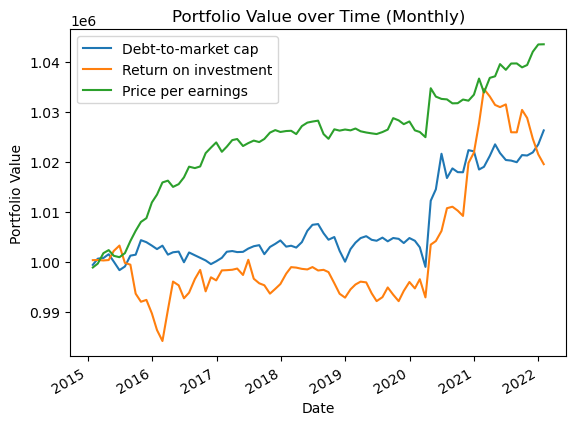

In [120]:
_, _, dmc_port_m = simulate(dmc_std[stocks],50000,subsample[stocks],period='M')
_, _, roi_port_m = simulate(roi_std[stocks],50000,subsample[stocks],period='M')
_, _, ppe_port_m = simulate(ppe_std[stocks],50000,subsample[stocks],period='M')

portfolio_second = pd.concat([dmc_port_m.rename(columns={'PnL':'Debt-to-mkt cap'}),roi_port_m.rename(columns={'PnL':'RoI'}),ppe_port_m.rename(columns={'PnL':'PPE'})],axis=1)
portfolio_second.plot()

plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend(['Debt-to-market cap','Return on investment','Price per earnings'])
plt.title('Portfolio Value over Time (Monthly)')

We must change the annualization to 12 when we switch to monthly, otherwise we may have *extremely* good looking numbers.

In [121]:
metrics(portfolio_second,12)

,Mean,Volatility,Sharpe Ratio,VaR (.05),CVaR (.05),Skewness,Kurtosis,Sortino Ratio
Debt-to-mkt cap,0.003819,0.007677,0.497480,-0.002159,-0.003423,2.509864,13.984888,0.286054
RoI,0.002764,0.010090,0.273950,-0.003761,-0.004660,1.142175,2.805581,0.157926
PPE,0.006257,0.005492,1.139277,-0.001576,-0.002097,2.170987,11.616921,0.736949


We see that our plot becomes more jagged (as expected as our trades become more discrete). We also see that our debt-to-market portfolio has better performance while our RoI portfolio becomes worse. Our PPE portfolio also decreases in performance. We also see extremely high kurtosis in the debt-to-mkt-cap and PPE portfolios. We will go back to weekly for the rest of the assignment but monthly analysis can also be done. It is reasonable to see what happens when we combine these ratios into a singular ratio. We will do this next.

***

**4.3 Combination of Financial Ratios**

We will examine what happens when we combine these financial ratios rather than independently using them. By combining them, it suggests that we will only enter the absolute *best* stocks in all three metrics. Mathematically, there may be some correlation between these financial ratios and it isn't as straight forward as adding them, as we saw earlier. Nonetheless, we will proceed.

For now, let's assume a equally weighted *portfolio* of these financial ratios (i.e each ratio is weighted by $\frac{1}{3}$)

In [130]:
summed_ratio = (1/3)*dmc_std + (1/3)*roi_std + (1/3)*ppe_std

For fun, let's also plot the median to see the behavior. This is a little weird as these are already all standardized, but nonetheless, let's see what observations we can make.

Text(0.5, 1.0, 'Combined ratio over time')

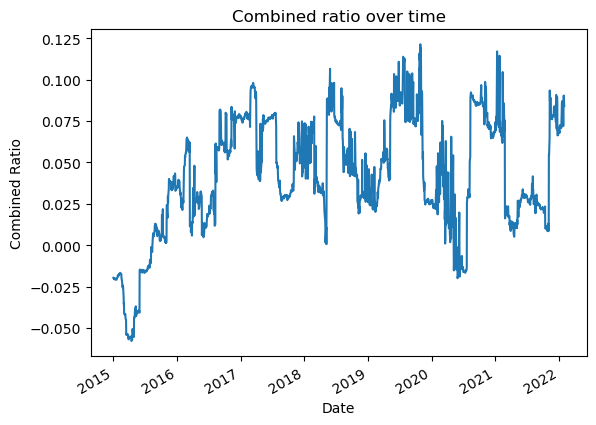

In [139]:
summed_ratio.median(axis=1).plot()
plt.xlabel('Date')
plt.ylabel('Combined Ratio')
plt.title('Combined ratio over time')

We can potentially see a trend in the combined ratio over time. However, it does appear to be more stationary after the brief initial run up. However, many *mean-reverting* trades would take an extended period of time and may not be worth (if it is even stationary in the first place). Let's calculate the performance with this combined ratio as the signal. We will use the same function from above (with the same quantiles).

In [132]:
_, _, summed_port = simulate(summed_ratio,50000)

Text(0.5, 1.0, 'Portfolio value of combined ratios over time (Weekly)')

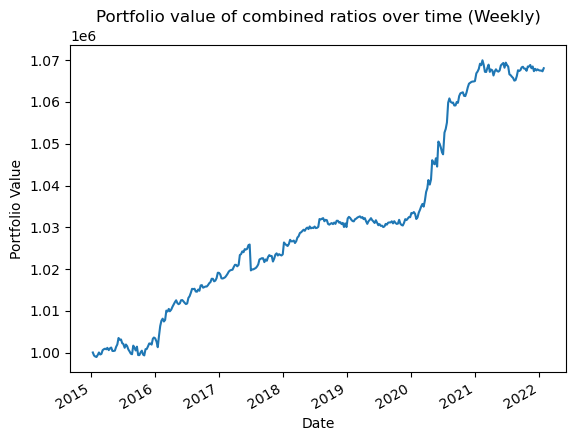

In [137]:
summed_port.plot(legend=False)
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio value of combined ratios over time (Weekly)')

In [134]:
metrics(summed_port)

,Mean,Volatility,Sharpe Ratio,VaR (.05),CVaR (.05),Skewness,Kurtosis,Sortino Ratio
PnL,0.009321,0.006597,1.412835,-0.000909,-0.00152,0.838187,12.875372,1.30288


We see that this portfolio is generally pretty good and has a high Sharpe Ratio. However, the Sharpe Ratio is slightly lower than the portfolio with PPE as a sole predictor. We'll also evaluate the change in ratios to see if there's any impact. Is it interesting to note that a big run-up in the portfolo value happens during COVID and we don't really see a big drawdown. We also see the portfolio continuously going up, even when the summed ratio's are moving in a range.

***

**4.4 Difference in Ratios**

First, we'll construct the ratio differences. We will simplify this by calculating the difference between T and T + 1. Mathematically, this may not be this sample. In this case, we'll assume since that they're standardize, there's no need to do anything else and we can subtract the atios directly. It's a little weird as these are z-scores from different distributions (these distributions change daily as we restandardize on a daily basis). We will live with this approximation and assume that the distributions don't change significantly on a day-to-day basis. We'll first calculate this difference and examine the univariate portfolios, similar to what we did earlier. In the future, it may be good to look at a percent change rather than a simple difference.

In [140]:
dmc_diff = dmc_std.diff().dropna() 
roi_diff = roi_std.diff().dropna() 
ppe_diff = ppe_std.diff().dropna()

We will drop the empty row that results when we use .diff(). However, this has no effect as we skip the first day anyways. This is due to the fact that we only want to trade on weeks / months which include more than one day. It so happens that the first trading day in 2015 lies on a Friday, so we actually exclude that week.

In [144]:
_, _, dmc_port = simulate(dmc_diff[stocks],50000,subsample[stocks])
_, _, roi_port = simulate(roi_diff[stocks],50000,subsample[stocks])
_, _, ppe_port = simulate(ppe_diff[stocks],50000,subsample[stocks])

Text(0.5, 1.0, 'Portfolio Value over Time (Ratio Differences)')

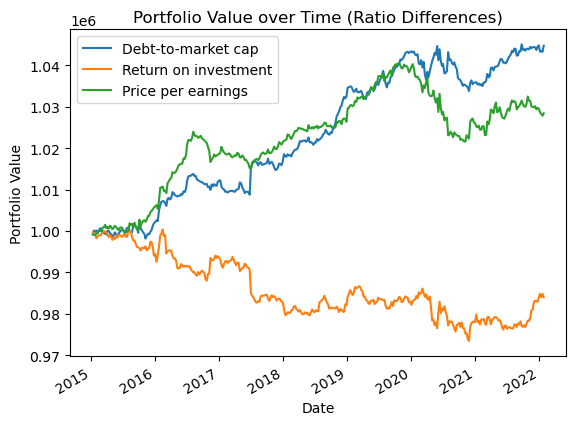

In [147]:
portfolio_fourth = pd.concat([dmc_port.rename(columns={'PnL':'Debt-to-mkt cap difference'}),roi_port.rename(columns={'PnL':'ROI difference'}),ppe_port.rename(columns={'PnL':'PPE difference'})],axis=1)
portfolio_fourth.plot()

plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend(['Debt-to-market cap','Return on investment','Price per earnings'])
plt.title('Portfolio Value over Time (Ratio Differences)')

We see that the price per earnings and debt-to-market cap ratios look to move together. However, the ROI portfolio value decreases. Let's quantitatively determine the performance of these portfolios.

In [148]:
metrics(portfolio_fourth)

,Mean,Volatility,Sharpe Ratio,VaR (.05),CVaR (.05),Skewness,Kurtosis,Sortino Ratio
Debt-to-mkt cap difference,0.006310,0.006320,0.998373,-0.001196,-0.001786,0.976835,8.421356,0.936619
ROI difference,-0.002220,0.006923,-0.320633,-0.001383,-0.002250,-0.341216,6.087820,-0.259946
PPE difference,0.004099,0.006666,0.614825,-0.001022,-0.002110,0.111278,4.572382,0.519631


We can see that the performance of these portfolios are not that great. We see that the Sharpe Ratios are lower than what we've seen previously. The skew statistics are also quite high, though the max is smaller. We see that the return-on-investment portfolio has a negative trend. Let's try combining these differences, but this time, give return on investment a negative weight while the other ones carry a positive weight. In other words, let's calculate a summed ratio equal to $\frac{2}{3} DMC + \frac{2}{3} PPE - \frac{1}{3} PPE$.

In [149]:
summed_ratio = (2/3)*dmc_diff + (2/3)*ppe_diff - (1/3)*roi_diff
_, _, summed_port = simulate(summed_ratio[stocks],50000,subsample[stocks])

Text(0.5, 1.0, 'Summed Ratio Difference Portfolio')

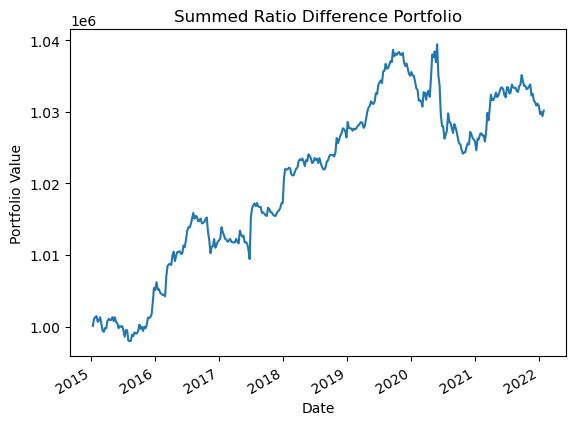

In [150]:
summed_port.plot(legend=False)
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Summed ratio difference portfolio value')

In [151]:
metrics(summed_port)

,Mean,Volatility,Sharpe Ratio,VaR (.05),CVaR (.05),Skewness,Kurtosis,Sortino Ratio
PnL,0.004208,0.006396,0.657853,-0.001025,-0.001694,0.751362,7.450919,0.625948


We see what we expect. This portfolio performs better than the RoI and PPE portfolios, but doesn't outperform the debt-to-market-cap portfolio. The Sharpe Ratio is 0.66, which is decent. These were just guesses to find a combination that could be profitable. It dThis strategy could be better if optimization was conducted to find the best weights. This could be a viable approach in the future. This is not done here as the focus of this assignment is predominantly data retrieval and filtering. We've seen that for our initial portfolios, the ratios themselves perform better than the changes. Now, we'll look at changing the quantiles.

***

**4.5 Different Quantile Weights**

It is now good to examine what happens when we remove the equal weights. Initially, we used equal weights to determine the position size of each stock. In other words, we had the same dollar value of each stock regardless of which quantile it was in - as long as it was in the top and bottom decile. Now, we will have equal long/short weights between the top/bottom 5th quantile and the next 15th quantile following that. We will go back to our original data (the standardized three ratios).

Here, we have chosen the upper and lower quantiles to be 0.95 and 0.05 respectively. We will place 1/4 of our notional value to be in each of these categories. Our second set of quantiles will be from 0.8 - 0.95 and 0.05 to 0.20. We will also play 1/4 of our notional value in these buckets and split our position sizes accordingly. 

Text(0.5, 1.0, 'Portfolio Value over time (Different Quantiles)')

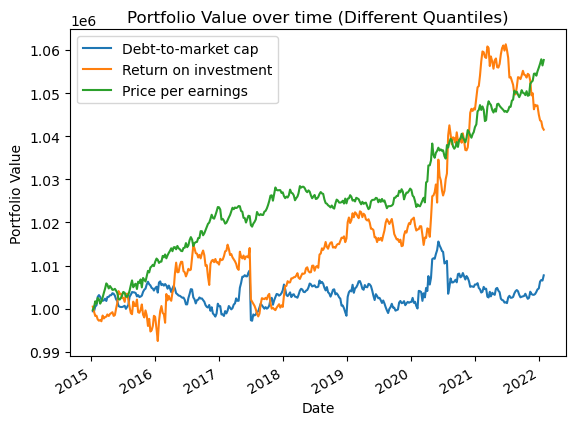

In [190]:
_, _, dmc_port_qw = simulate(dmc_std[stocks],50000,subsample[stocks],upper_quantile=0.95,lower_quantile=0.05,use_more_quantiles=True,additional=0.15)
_, _, roi_port_qw = simulate(roi_std[stocks],50000,subsample[stocks],upper_quantile=0.95,lower_quantile=0.05,use_more_quantiles=True,additional=0.15)
_, _, ppe_port_qw = simulate(ppe_std[stocks],50000,subsample[stocks],upper_quantile=0.95,lower_quantile=0.05,use_more_quantiles=True,additional=0.15)

portfolio_fifth = pd.concat([dmc_port_qw.rename(columns={'PnL':'Debt-to-mkt cap'}),roi_port_qw.rename(columns={'PnL':'RoI'}),ppe_port_qw.rename(columns={'PnL':'PPE'})],axis=1)
portfolio_fifth.plot()

plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend(['Debt-to-market cap','Return on investment','Price per earnings'])
plt.title('Portfolio Value over time (Different Quantiles)')

In [187]:
metrics(portfolio_fifth)

,Mean,Volatility,Sharpe Ratio,VaR (.05),CVaR (.05),Skewness,Kurtosis,Sortino Ratio
Debt-to-mkt cap,0.001207,0.008281,0.145750,-0.001194,-0.002469,-2.912083,32.094872,0.095033
RoI,0.005762,0.012493,0.461248,-0.002205,-0.003426,0.181675,9.909991,0.404624
PPE,0.007988,0.006450,1.238432,-0.001141,-0.001595,0.660515,2.751720,1.403782


We see that this portfolio also performs worse than our other portfolios we've seen. We see that the highest Sharpe Ratio is 1.24 from PPE. PPE has consistently been the best performing ratio during this time. Compared to our first plot (where we used each ratio univariately), we see that they follow similar trends. However, the ROI portfolio value is higher, though the Sharpe is lower. Let's do a similar analysis and try summing them.

In [188]:
summed_ratio = (1/3)*dmc_std + (1/3)*roi_std + (1/3)*ppe_std

Text(0.5, 1.0, 'Portfolio Value over Time (Summed Ratios)')

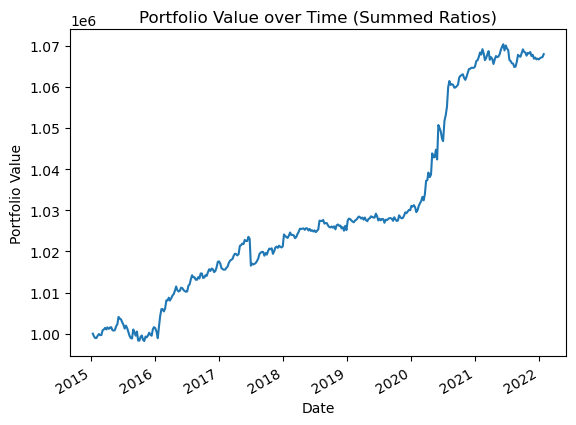

In [189]:
_, _, summed_port = simulate(summed_ratio[stocks],50000,subsample[stocks],use_more_quantiles=True)
summed_port.plot(legend=False)
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value over Time (Summed Ratios)')

In [191]:
metrics(summed_port)

,Mean,Volatility,Sharpe Ratio,VaR (.05),CVaR (.05),Skewness,Kurtosis,Sortino Ratio
PnL,0.009317,0.007391,1.260526,-0.001006,-0.001696,1.338565,15.886176,1.217635


We see that here, the Sharpe Ratio improves. In fact, it is better than any of the standalone ratios from the previous section. This is an interesting phenomenom and more analysis should be done into the correlation. This could be due to differing correlations depending on the given quantile. 
We will examine some correlations in the following section, though to broader market factors rather than the quantiles themselves.
***

## 5 Return Correlation Analysis

In this section, we will look at correlations between some of the portfolios and strategies. In quantitative finance, the correlations between strategies is extremely important in diversification and as a result, modern portfolio theory. First, let's look at the correlation between the strategies. Here, we will focus explicitly on the best strategy (which was in fact our first portfolio!)

***

**5.1 Correlation between financial ratios**

Let's first look at the correlation between the returns of our different strategies (explicitly based on one financial ratio)

<AxesSubplot: >

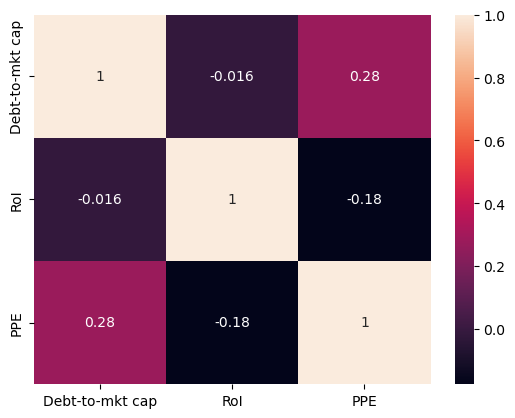

In [192]:
sns.heatmap(portfolio_first.pct_change().corr(),annot=True)

We see that the returns of all the strategies are relatively uncorrelated. The correlation between ROI and Debt-to-market cap is essentially 0. The highest correlatoin here is 0.28, which is still quite low. This is between debt-to-market-cap and price per earnings.

***

**5.2 Correlation to Fama-French Factors**

We see how correlated these factor are correlated to other financial ratios, but let's see how they're correlated to the Fama-French factors. These factors are popular as a benchmark when comparing certain strategies or funds to the market. These factors have been shown to explain much of the market returns. This comparison can see if we're actually generating returns.

<AxesSubplot: >

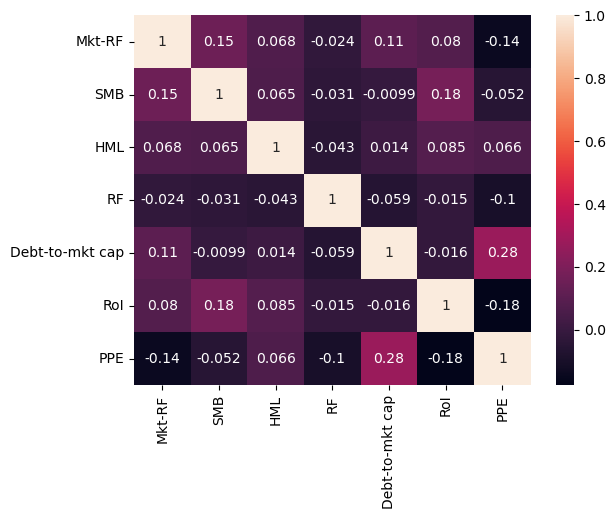

In [193]:
FF_sample = FF.loc['2015-01-01':'2022-01-31']
FFport = pd.concat([FF_sample,portfolio_first.pct_change()],axis=1)
sns.heatmap(FFport.corr(),annot=True)

Interestingly enough, we can see that our strategy is also uncorrelated to these market factors. We see that the PPE strategy actually has a -0.14 correlation to the market. If you look back, the PPE strategy caused our portfolio to steadily grow, even throughout the COVID-19 pandemic era. This trend is in place for all the market factors. The highest correlation is 0.085, which is between the value factor and return on investment. Regardless, this strategy is relatively uncorrelated to the market in terms of returns.

On a side-note, it's interesting to see that the Fama-French factors are relatively uncorrelated during this time-frame. For example, we see that the Mkt-RF has a 0.15 correlation with SMB and a 0068 correlation with HML. However, from last homework (2020 - 2022), we see a much higher correlation. For example, SMB and Mkt-RF have a 0.34 correlation compared to 0.15. However, we are looking at the in-sample returns. In reality, it would be good to examine the out-of-sample performance.

***

## 6 Conclusion

In this assignment, we filtered out stock tickers in order to create a quantile-trading strategy. We used three financial ratios: debt-to-market-cap, return on investment, and price-per-earnings. However, Quandl only gives these ratios for each quarter and as a result, we had to convert these to daily values in order to trade on a somewhat frequent basis. The stocks were filtered in a variety of ways: mainly to ensure that all the financial ratios for these tickers could be built so we could make these comparisons. Industry, and debt-to-market-cap ratios were initially filtered out before moving onto other types of filtering that eliminated tickers without data.

After filtering the data, we were able to re-construct financial ratios by using the quarterly ratios as an initial estimate. This involved scaling the existing values by some change in price (or the price itself). Financial ratio data is filed by a company when the period ends. However, this data isn't published to the public until the filing date (usually a month later). This results in a delay when calculating these ratios, which is seen when we interpolate the financial ratios to each day. We plotted the ratios and saw that COVID-19 had a major effect in all the ratios. We also looked at the correlations between the ratios themselves. After this, we created our quantile trading strategy with these metrics. We would buy the top 10% of stocks with a certain ratio while we'd short the bottom 10% of stocks in that same ratio. Our trading strategy was simplified in that we entered at the beginning of every week and sold at the end to make rebalancing simpler. We also included the presence of lending rates (i.e risk-free rate). However, this effect was very marginal as the interest rates throughout the period of 2015-2022 were almost non-existent. 

First, we calculated single portfolios based on a single signal (ratio). We then normalized these metrics so we could compare them across one another. The ratios showed to have high tail risk and as a result, mean reversion could potentially be very dangerous (as seen with COVID). After creating single portfolios based on one metric, we combined them in a uniformed manner in attempts to create a better portfolio / strategy. This wasn't too successful in our initial estimates, though optimization techniques can be used in the future to see if any performance increases can be gained. The initial Sharpe ratio was pretty good, though this was with the PPE ratio. Even during COVID, the PPE strategy still generated returns. Throughout the entire assignment, PPE was shown to be the best ratio in that it generated the highest Sharpes consistently. 

We then moved onto using the differences of the ratios. We found that the ratios themselves were better when it came to market return (calculated with a Sharpe Ratio) rather than the ratio differences. However, we calculated simple differences rather than percent changes. In the future, we could use percent changes and see if there is a difference. Simple differences were used as we already normalized the variables for some point of time. Statistically, we approximated that the distribution at T and T + 1 were about the same and thus did this. If we wanted to be more specific, we could look into more stationarity or distribution tests. We also tried changing the quantiles. More specifically, we first calculated our returns by assuming that all the stocks had the same magnitiude in dollar value. Now, we set 50% of our allocation to the top/bottom 5% while setting another 50% to the top/bottom 15% afterwards (i.e .80-.95). We found that the summed portfolio performed better than the individual portfolios when allowing for changes in dollar allocation of stocks.

Finally, we compared our financial ratio univariate portfolio returns to each other. We see that the returns of the portfolios are relatively uncorrelated. When we check the Fama-French factors, we also see it is uncorrelated. In the future, more analysis should be done on these correlations. For the financial ratio correlations, we see that PPE and ROI have a negative correlation even though their prices look relatively correlated. Investigation could be done on certain regions to determine what is happening. Graphically, it appears as the large areas of divergence is causing this.

In the future, we could perform optimization on various parts of the assignment to see if we can generate even better Sharpe Ratios. For example, we can see what the best weights are for when combining the ratios or look at what quantiles are optimal, for equal weighted and variable weighitng. In addition, we could use different timeperiods to gauge a better understanding of the stock market performance. We could move this strategy to the past year and see how it performs, as the market environment in the past year is extremely different to the past 7. There are also other financial ratios. We could use other financial ratios and see which ones may lead to better returns. Finally, we could try a different type of quantile trading strategy. Instead of entering at the beginning of each week/month and exiting and the end of hte period, we could continuously rebalance our portfolio and only exit when we exit a quantile. Additionally, we could also incorporate regions where we simply hold our positions rather than exit, though this may result in our portfolio not necessarily being balanced at all times. 